# 04 · Train Cross-Encoder + Calibrate

## Purpose

Train a cross-encoder reranker and calibrate its probabilities on the dev split.

## Inputs

- `data/processed/pairs/train.jsonl` with labeled pairs.
- `data/processed/pairs/dev.jsonl` for validation and calibration.

## Outputs

- `models/cross_encoder/` with fine-tuned cross-encoder weights.
- `models/calibration/cross_iso.pkl` (or equivalent) storing the calibration model.

## Steps

1. Load `cross-encoder/ms-marco-MiniLM-L6-v2` (or L-2 variant) as the base checkpoint.
2. Fine-tune using binary cross-entropy loss with batch size 32, learning rate 1.5e-5, for 2–3 epochs.
3. Track dev metrics such as AUC and MAP to monitor overfitting.
4. Collect dev logits/probabilities and fit an isotonic or Platt calibrator (dev only).
5. Save the calibrated model and visualize reliability (ECE or curve) for reporting.

## Acceptance Checks

- `models/calibration/cross_iso.pkl` (or chosen filename) exists after the run.
- Dev AUC/MAP along with calibration diagnostics (reliability or ECE) are reported.

In [11]:
import pandas as pd
import numpy as np
import json
from pathlib import Path
import pickle
import torch
from sentence_transformers import CrossEncoder
from sklearn.metrics import roc_auc_score, average_precision_score, log_loss
from sklearn.calibration import calibration_curve, IsotonicRegression
import matplotlib.pyplot as plt

# Set random seeds
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Check device
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

Using device: mps


## 1. Load training and dev pairs

In [12]:
def load_pairs(jsonl_path):
    """Load pairs from JSONL file"""
    pairs = []
    with open(jsonl_path, "r") as f:
        for line in f:
            pairs.append(json.loads(line))
    return pairs

# Load pairs
train_pairs = load_pairs("../data/processed/pairs/train.jsonl")
dev_pairs = load_pairs("../data/processed/pairs/dev.jsonl")

print(f"✓ Loaded {len(train_pairs)} train pairs")
print(f"✓ Loaded {len(dev_pairs)} dev pairs")
print(f"\n  Sample pair:")
print(f"    Artifact: {train_pairs[0]['artifact_text'][:60]}...")
print(f"    Control: {train_pairs[0]['control_text'][:60]}...")
print(f"    Label: {train_pairs[0]['label']}")

✓ Loaded 59373 train pairs
✓ Loaded 11683 dev pairs

  Sample pair:
    Artifact: User 'svc-api' failed login 11 times in 2 minutes; account w...
    Control: System Component Inventory. Maintain accurate, up-to-date as...
    Label: 0


## 2. Load and train cross-encoder

In [13]:
# Load base cross-encoder model
BASE_MODEL = "cross-encoder/ms-marco-MiniLM-L6-v2"
OUTPUT_PATH = "../models/cross_encoder"

print(f"Loading base model: {BASE_MODEL}")
print("This may take a few minutes on first run (downloading model)...")
print("Model size: ~90MB")

try:
    model = CrossEncoder(BASE_MODEL, num_labels=1, device=device)
    print(f"✓ Model loaded successfully on {device}")
except Exception as e:
    print(f"❌ Error loading model: {e}")
    print("\nTroubleshooting:")
    print("1. Check internet connection")
    print("2. Clear HuggingFace cache: rm -rf ~/.cache/huggingface/")
    print("3. Try downloading manually: huggingface-cli download cross-encoder/ms-marco-MiniLM-L6-v2")
    raise

# Training configuration
BATCH_SIZE = 32
NUM_EPOCHS = 2
LEARNING_RATE = 1.5e-5

print(f"\nTraining configuration:")
print(f"  Epochs: {NUM_EPOCHS}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Output path: {OUTPUT_PATH}")

# Create output directory
Path(OUTPUT_PATH).mkdir(parents=True, exist_ok=True)

print(f"\n{'='*60}")
print(f"Starting training...")
print(f"{'='*60}\n")

Loading base model: cross-encoder/ms-marco-MiniLM-L6-v2
This may take a few minutes on first run (downloading model)...
Model size: ~90MB
✓ Model loaded successfully on mps

Training configuration:
  Epochs: 2
  Batch size: 32
  Learning rate: 1.5e-05
  Output path: ../models/cross_encoder

Starting training...



In [14]:
# Prepare training data for CrossEncoder
from torch.utils.data import DataLoader
from sentence_transformers import InputExample

# Convert pairs directly to InputExample format
train_input_examples = [
    InputExample(texts=[pair['artifact_text'], pair['control_text']], label=float(pair['label']))
    for pair in train_pairs
]

print(f"✓ Created {len(train_input_examples)} training examples")

# Create DataLoader
train_dataloader = DataLoader(train_input_examples, shuffle=True, batch_size=BATCH_SIZE)

print(f"✓ Created DataLoader with batch size {BATCH_SIZE}")
print(f"  Total batches: {len(train_dataloader)}")

# Train the model
print(f"\n{'='*60}")
print(f"Training...")
print(f"{'='*60}\n")

model.fit(
    train_dataloader=train_dataloader,
    epochs=NUM_EPOCHS,
    warmup_steps=int(len(train_dataloader) * 0.1),  # 10% warmup
    show_progress_bar=True,
    output_path=OUTPUT_PATH,
)

print(f"\n{'='*60}")
print(f"✓ Training complete!")
print(f"{'='*60}")

✓ Created 59373 training examples
✓ Created DataLoader with batch size 32
  Total batches: 1856

Training...



/Users/mikiyas/development/hodwa/crs/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
500,0.154600
1000,0.102100
1500,0.082500
2000,0.079500
2500,0.073100
3000,0.064900
3500,0.067600



✓ Training complete!


In [15]:
# Explicitly save the trained model
print(f"\nSaving model to {OUTPUT_PATH}...")
model.save(OUTPUT_PATH)
print(f"✓ Model saved successfully")

# Verify model files exist
saved_files = list(Path(OUTPUT_PATH).glob("*"))
print(f"  Saved files: {[f.name for f in saved_files]}")


Saving model to ../models/cross_encoder...
✓ Model saved successfully
  Saved files: ['model.safetensors', 'tokenizer_config.json', 'special_tokens_map.json', 'config.json', 'tokenizer.json', 'README.md', 'vocab.txt']


## 3. Evaluate on dev set and get predictions for calibration

In [16]:
# Get predictions on dev set
dev_text_pairs = [[pair['artifact_text'], pair['control_text']] for pair in dev_pairs]
dev_labels = np.array([pair['label'] for pair in dev_pairs])

print("Predicting on dev set...")
dev_scores = model.predict(
    dev_text_pairs,
    batch_size=BATCH_SIZE,
    show_progress_bar=True,
    convert_to_numpy=True
)

# Convert logits to probabilities using sigmoid
dev_probs = 1 / (1 + np.exp(-dev_scores))

print(f"\n✓ Got predictions for {len(dev_probs)} dev samples")
print(f"  Score range: [{dev_scores.min():.3f}, {dev_scores.max():.3f}]")
print(f"  Prob range: [{dev_probs.min():.3f}, {dev_probs.max():.3f}]")

Predicting on dev set...


Batches:   0%|          | 0/366 [00:00<?, ?it/s]


✓ Got predictions for 11683 dev samples
  Score range: [-10.775, 8.279]
  Prob range: [0.000, 1.000]


In [17]:
# Compute dev metrics
auc = roc_auc_score(dev_labels, dev_probs)
ap = average_precision_score(dev_labels, dev_probs)
logloss = log_loss(dev_labels, dev_probs)

print("\n" + "="*60)
print("DEV SET METRICS (Before Calibration)")
print("="*60)
print(f"  AUC (ROC):            {auc:.4f}")
print(f"  MAP (Avg Precision):  {ap:.4f}")
print(f"  Log Loss:             {logloss:.4f}")


DEV SET METRICS (Before Calibration)
  AUC (ROC):            0.9828
  MAP (Avg Precision):  0.8604
  Log Loss:             0.0637


## 4. Calibrate probabilities using Isotonic Regression

In [18]:
# Fit isotonic calibrator on dev set
calibrator = IsotonicRegression(out_of_bounds="clip")
calibrator.fit(dev_probs, dev_labels)

print("✓ Fitted Isotonic Regression calibrator on dev set")

# Get calibrated probabilities
dev_probs_calibrated = calibrator.predict(dev_probs)

# Compute metrics after calibration
logloss_calibrated = log_loss(dev_labels, dev_probs_calibrated)

print("\n" + "="*60)
print("DEV SET METRICS (After Calibration)")
print("="*60)
print(f"  Log Loss (calibrated): {logloss_calibrated:.4f}")
print(f"  Improvement:           {logloss - logloss_calibrated:.4f}")

# Save calibrator
calibration_dir = Path("../models/calibration")
calibration_dir.mkdir(parents=True, exist_ok=True)
calibrator_path = calibration_dir / "cross_iso.pkl"

with open(calibrator_path, "wb") as f:
    pickle.dump(calibrator, f)

print(f"\n✓ Saved calibrator to {calibrator_path}")

✓ Fitted Isotonic Regression calibrator on dev set

DEV SET METRICS (After Calibration)
  Log Loss (calibrated): 0.0554
  Improvement:           0.0082

✓ Saved calibrator to ../models/calibration/cross_iso.pkl


## 5. Calibration diagnostics (reliability curve and ECE)


CALIBRATION DIAGNOSTICS
  ECE (before calibration): 0.0099
  ECE (after calibration):  0.0000
  ECE improvement:          0.0099

✓ Saved reliability curve to ../models/calibration/reliability_curve.png


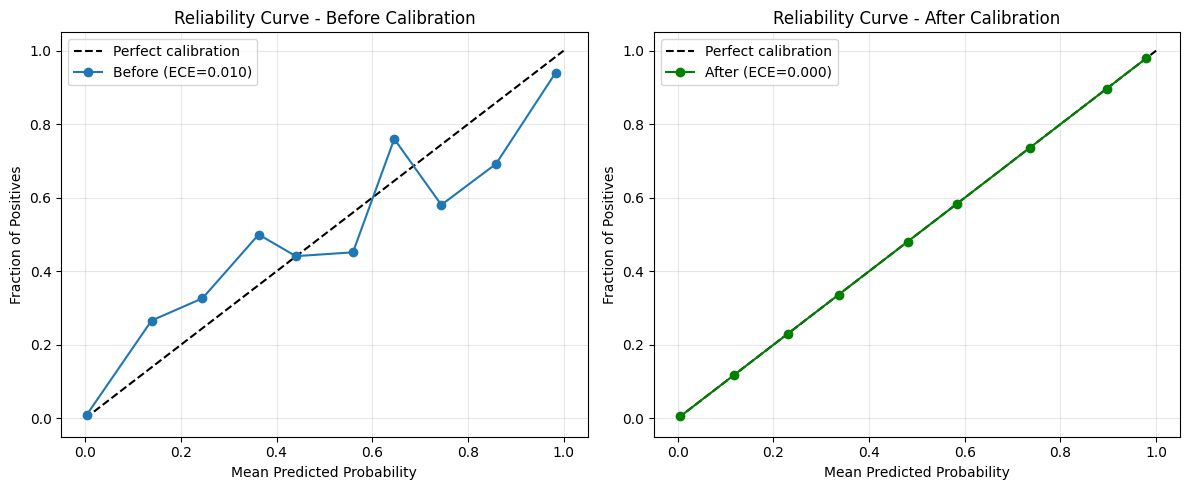

In [19]:
# Compute calibration curve (before and after)
n_bins = 10
prob_true_before, prob_pred_before = calibration_curve(dev_labels, dev_probs, n_bins=n_bins, strategy='uniform')
prob_true_after, prob_pred_after = calibration_curve(dev_labels, dev_probs_calibrated, n_bins=n_bins, strategy='uniform')

# Compute Expected Calibration Error (ECE)
def compute_ece(y_true, y_prob, n_bins=10):
    """Compute Expected Calibration Error"""
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=n_bins, strategy='uniform')
    bin_totals = np.histogram(y_prob, bins=np.linspace(0, 1, n_bins+1))[0]
    non_empty = bin_totals > 0
    ece = np.sum(bin_totals[non_empty] * np.abs(prob_true - prob_pred)) / len(y_true)
    return ece

ece_before = compute_ece(dev_labels, dev_probs, n_bins=n_bins)
ece_after = compute_ece(dev_labels, dev_probs_calibrated, n_bins=n_bins)

print("\n" + "="*60)
print("CALIBRATION DIAGNOSTICS")
print("="*60)
print(f"  ECE (before calibration): {ece_before:.4f}")
print(f"  ECE (after calibration):  {ece_after:.4f}")
print(f"  ECE improvement:          {ece_before - ece_after:.4f}")

# Plot reliability curve
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Before calibration
ax1.plot([0, 1], [0, 1], 'k--', label='Perfect calibration')
ax1.plot(prob_pred_before, prob_true_before, 'o-', label=f'Before (ECE={ece_before:.3f})')
ax1.set_xlabel('Mean Predicted Probability')
ax1.set_ylabel('Fraction of Positives')
ax1.set_title('Reliability Curve - Before Calibration')
ax1.legend()
ax1.grid(True, alpha=0.3)

# After calibration
ax2.plot([0, 1], [0, 1], 'k--', label='Perfect calibration')
ax2.plot(prob_pred_after, prob_true_after, 'o-', color='green', label=f'After (ECE={ece_after:.3f})')
ax2.set_xlabel('Mean Predicted Probability')
ax2.set_ylabel('Fraction of Positives')
ax2.set_title('Reliability Curve - After Calibration')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(calibration_dir / "reliability_curve.png", dpi=100, bbox_inches='tight')
print(f"\n✓ Saved reliability curve to {calibration_dir / 'reliability_curve.png'}")
plt.show()

## 6. Acceptance checks

In [20]:
print("="*60)
print("ACCEPTANCE CHECKS")
print("="*60)

# Check 1: Calibration file exists
check1 = calibrator_path.exists()
print(f"\n✓ Check 1: Calibration file saved")
print(f"  Path: {calibrator_path}")
print(f"  Exists: {check1}")
print(f"  Size: {calibrator_path.stat().st_size / 1024:.2f} KB" if check1 else "  Size: N/A")
print(f"  Result: {'PASS' if check1 else 'FAIL'}")

# Check 2: Dev metrics reported
check2 = auc > 0 and ap > 0 and ece_after >= 0
print(f"\n✓ Check 2: Dev AUC/MAP and calibration diagnostics reported")
print(f"  AUC: {auc:.4f}")
print(f"  MAP: {ap:.4f}")
print(f"  ECE (after): {ece_after:.4f}")
print(f"  Result: {'PASS' if check2 else 'FAIL'}")

# Check 3: Model saved
model_saved = Path(OUTPUT_PATH).exists()
check3 = model_saved
print(f"\n✓ Check 3: Cross-encoder model saved")
print(f"  Path: {OUTPUT_PATH}")
print(f"  Exists: {model_saved}")
print(f"  Result: {'PASS' if check3 else 'FAIL'}")

# Overall
all_checks_passed = check1 and check2 and check3
print("\n" + "="*60)
if all_checks_passed:
    print("✅ ALL ACCEPTANCE CHECKS PASSED")
else:
    print("❌ SOME ACCEPTANCE CHECKS FAILED")
print("="*60)

ACCEPTANCE CHECKS

✓ Check 1: Calibration file saved
  Path: ../models/calibration/cross_iso.pkl
  Exists: True
  Size: 0.88 KB
  Result: PASS

✓ Check 2: Dev AUC/MAP and calibration diagnostics reported
  AUC: 0.9828
  MAP: 0.8604
  ECE (after): 0.0000
  Result: PASS

✓ Check 3: Cross-encoder model saved
  Path: ../models/cross_encoder
  Exists: True
  Result: PASS

✅ ALL ACCEPTANCE CHECKS PASSED
